# **The Navier-Stokes equations**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

The effects of different Reynold's numbers and mesh resolutions were explored on a fluid flowing past a cylinder. Lift and drag coefficients and Strouhal's number were calculated for different scenarios.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import scipy
import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

In [ ]:
# Set up experimental parameters

REYNOLDS_NUMBER = 100
RESOLUTION = 32
END_TIME = 30

DOWNLOAD_RESULTS = True

**Define domain and mesh**

We create a computational domain with width 4 and height 2, with a circle at x = 1.0, y = 1.0 (radius 0.2). We will vary the mesh size is to study the effects.

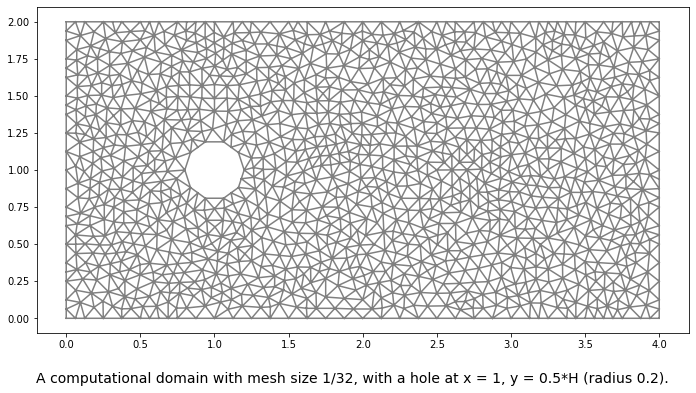

In [ ]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = RESOLUTION
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure(figsize=(12,6))
txt=f"A computational domain with mesh size 1/{RESOLUTION}, with a hole at x = 1, y = 0.5*H (radius 0.2)."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plot(mesh)
plt.show()

**Define finite element approximation spaces**

We define the approximation spaces for velocity and pressure as piecewise linear polynomials (we will use stabilization terms to get stability).

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

At the inflow we have velocity 1 in x and 0 in y. At the upper and lower boundaries we have a slip boundary condition. At the boundry of the cylinder we have a no-slip boundary condition. Finally, at the outflow boundary the pressure is set to 0.

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

We set the viscosity to correspond to the desired Reynold's number (the density and the characteristic speed is 1, the characteristic length is the diameter of the cylinder).

In [ ]:
# Set viscosity
#nu = 4.0e-3
nu = uin * 2 * rc / REYNOLDS_NUMBER

**Define method parameters**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

Prepare for time stepping by defining the momentum variational equation of NES on residual form, with stabilization terms.



In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [ ]:
# Define the direction of the force to be computed 
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_y = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_y = interpolate(psi_expression_y, V)

Force_y = inner((u1 - u0)/dt + grad(um1)*um1, psi_y)*dx - p1*div(psi_y)*dx + nu*inner(grad(um1), grad(psi_y))*dx

phi_x = 1.0
phi_y = 0.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression_x = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi_x = interpolate(psi_expression_x, V)

Force_x = inner((u1 - u0)/dt + grad(um1)*um1, psi_x)*dx - p1*div(psi_x)*dx + nu*inner(grad(um1), grad(psi_x))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 60

# Force computation data 
force_array_y = np.array(0.0)
force_array_y = np.delete(force_array_y, 0)
force_array_x = np.array(0.0)
force_array_x = np.delete(force_array_x, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

We solve NES using semi-discretization, stepping forward in time with the Trapetzoidal method.

The analysis of drag, lift and Strouhal's number is done after the first 15 seconds, when the system has settled into a consistent state.

The average lift and drag is calculated taking the average of the last 15 seconds.

The frequency needed to calculate Strouhal's number is calculated by calculating the reciprocal of the (average) time difference between the peaks of the lift forces.

In [ ]:
!rm results-NS/*

# Time stepping 
T = END_TIME
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_y = assemble(Force_y)
        F_x = assemble(Force_x)
        if (t > start_sample_time):
          force_array_y = np.append(force_array_y, normalization*F_y)
          force_array_x = np.append(force_array_x, normalization*F_x)
          time = np.append(time, t)

        k += 1

    #if t > plot_time:    
    if (t > plot_time) or (t + dt >= T):

        plt.figure(figsize=(10,20))

        plt.title('TEST')

        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        # plt.figure()
        plt.subplot(4, 1, 2);
        c = plot(u1, title="Velocity")
        plt.colorbar(c)  

        #plt.figure()
        plt.subplot(4, 1, 3);
        c = plot(p1, title="Pressure")
        plt.colorbar(c)  

        plot_time += T/plot_freq
        
        # plt.show()

        #plt.figure()
        plt.subplot(4, 1, 4);
        plt.title("Force")
        plt.plot(time, force_array_y, label="y")
        plt.plot(time, force_array_x, label="x")
        plt.xlabel('time')
        plt.legend()
        if not (t + dt >= T): plt.show()

    # Update time step
    u0.assign(u1)
    t += dt


last_half_force_y = force_array_y[len(force_array_y)//2:];
last_half_force_x = force_array_x[len(force_array_x)//2:];
last_half_time = time[len(force_array_y)//2:];

# Calculate Strouhal
from scipy.signal import find_peaks

peaks, _ = find_peaks(last_half_force_y, width=10)

if len(peaks) < 2:
  strouhal_txt = "N/A"
else:
  dist = []
  for i in range(1, len(peaks)):
    dist.append(last_half_time[peaks[i]] - last_half_time[peaks[i-1]]);

  #plt.plot(last_half_time, last_half_force_y)
  #plt.scatter([last_half_time[i] for i in peaks], [last_half_force_y[i] for i in peaks])

  strouhal_txt = repr(round(2*rc*1/np.mean(dist), 2))

avg_drag = round(np.mean(last_half_force_x), 2);
avg_lift = round(np.mean(last_half_force_y), 2);
max_lift = round(np.max(last_half_force_y), 2);

plt.subplot(4, 1, 1);
table = plt.table(colLabels=["Time", "Re", "Resolution", "Avg. Drag", "Avg. Lift", "Max Lift", "Strouhal"], \
                  cellText=[[repr(T), repr(REYNOLDS_NUMBER), repr(RESOLUTION), repr(avg_drag), repr(avg_lift), repr(max_lift), strouhal_txt]], \
                  cellLoc='center', fontsize = 40);
table.set_fontsize(14)
table.scale(1, 1.2)
plt.axis('off')
plt.tight_layout()
plt.show()

if DOWNLOAD_RESULTS:
  !tar -czvf results-NS.tar.gz results-NS
  files.download('results-NS.tar.gz')

Output hidden; open in https://colab.research.google.com to view.

---

# Figure 1

Velcity, pressure, drag coefficent, lift coeffiecent, and Strouhals number for Reynold's Number = 1, 10, 100, 1000

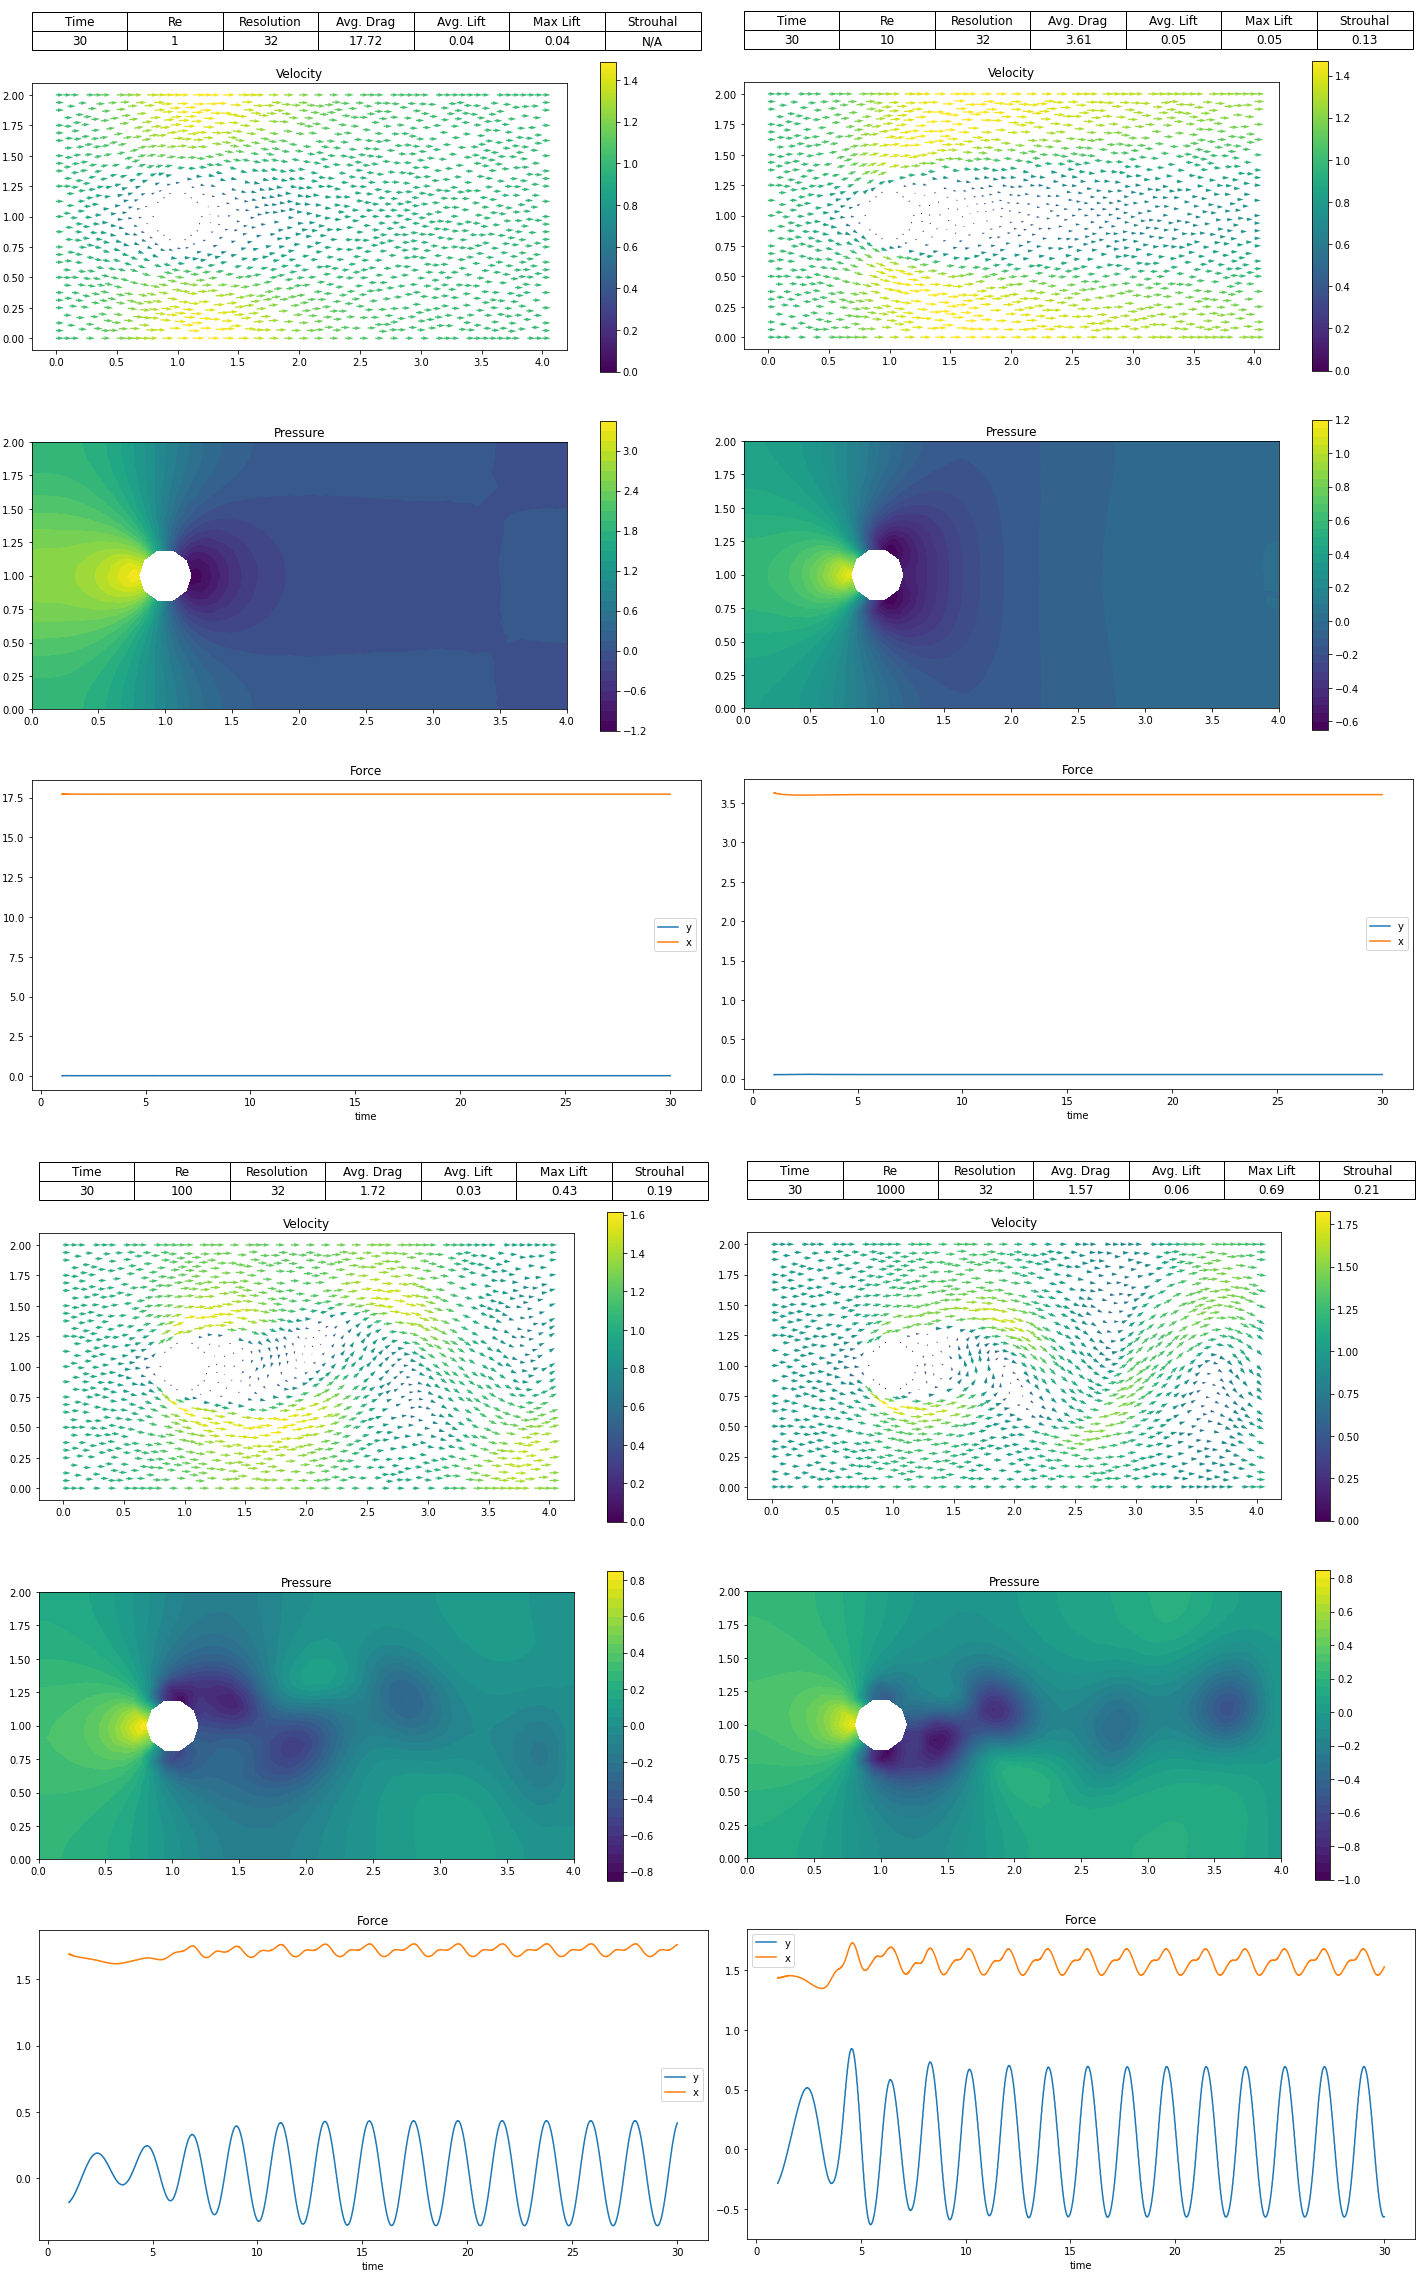

---

# Figure 2

Velcity, pressure, drag coefficent, lift coeffiecent, and Strouhals number for Reynold's Number = 100 and different mesh sizes 1/8, 1/16, 1/32.

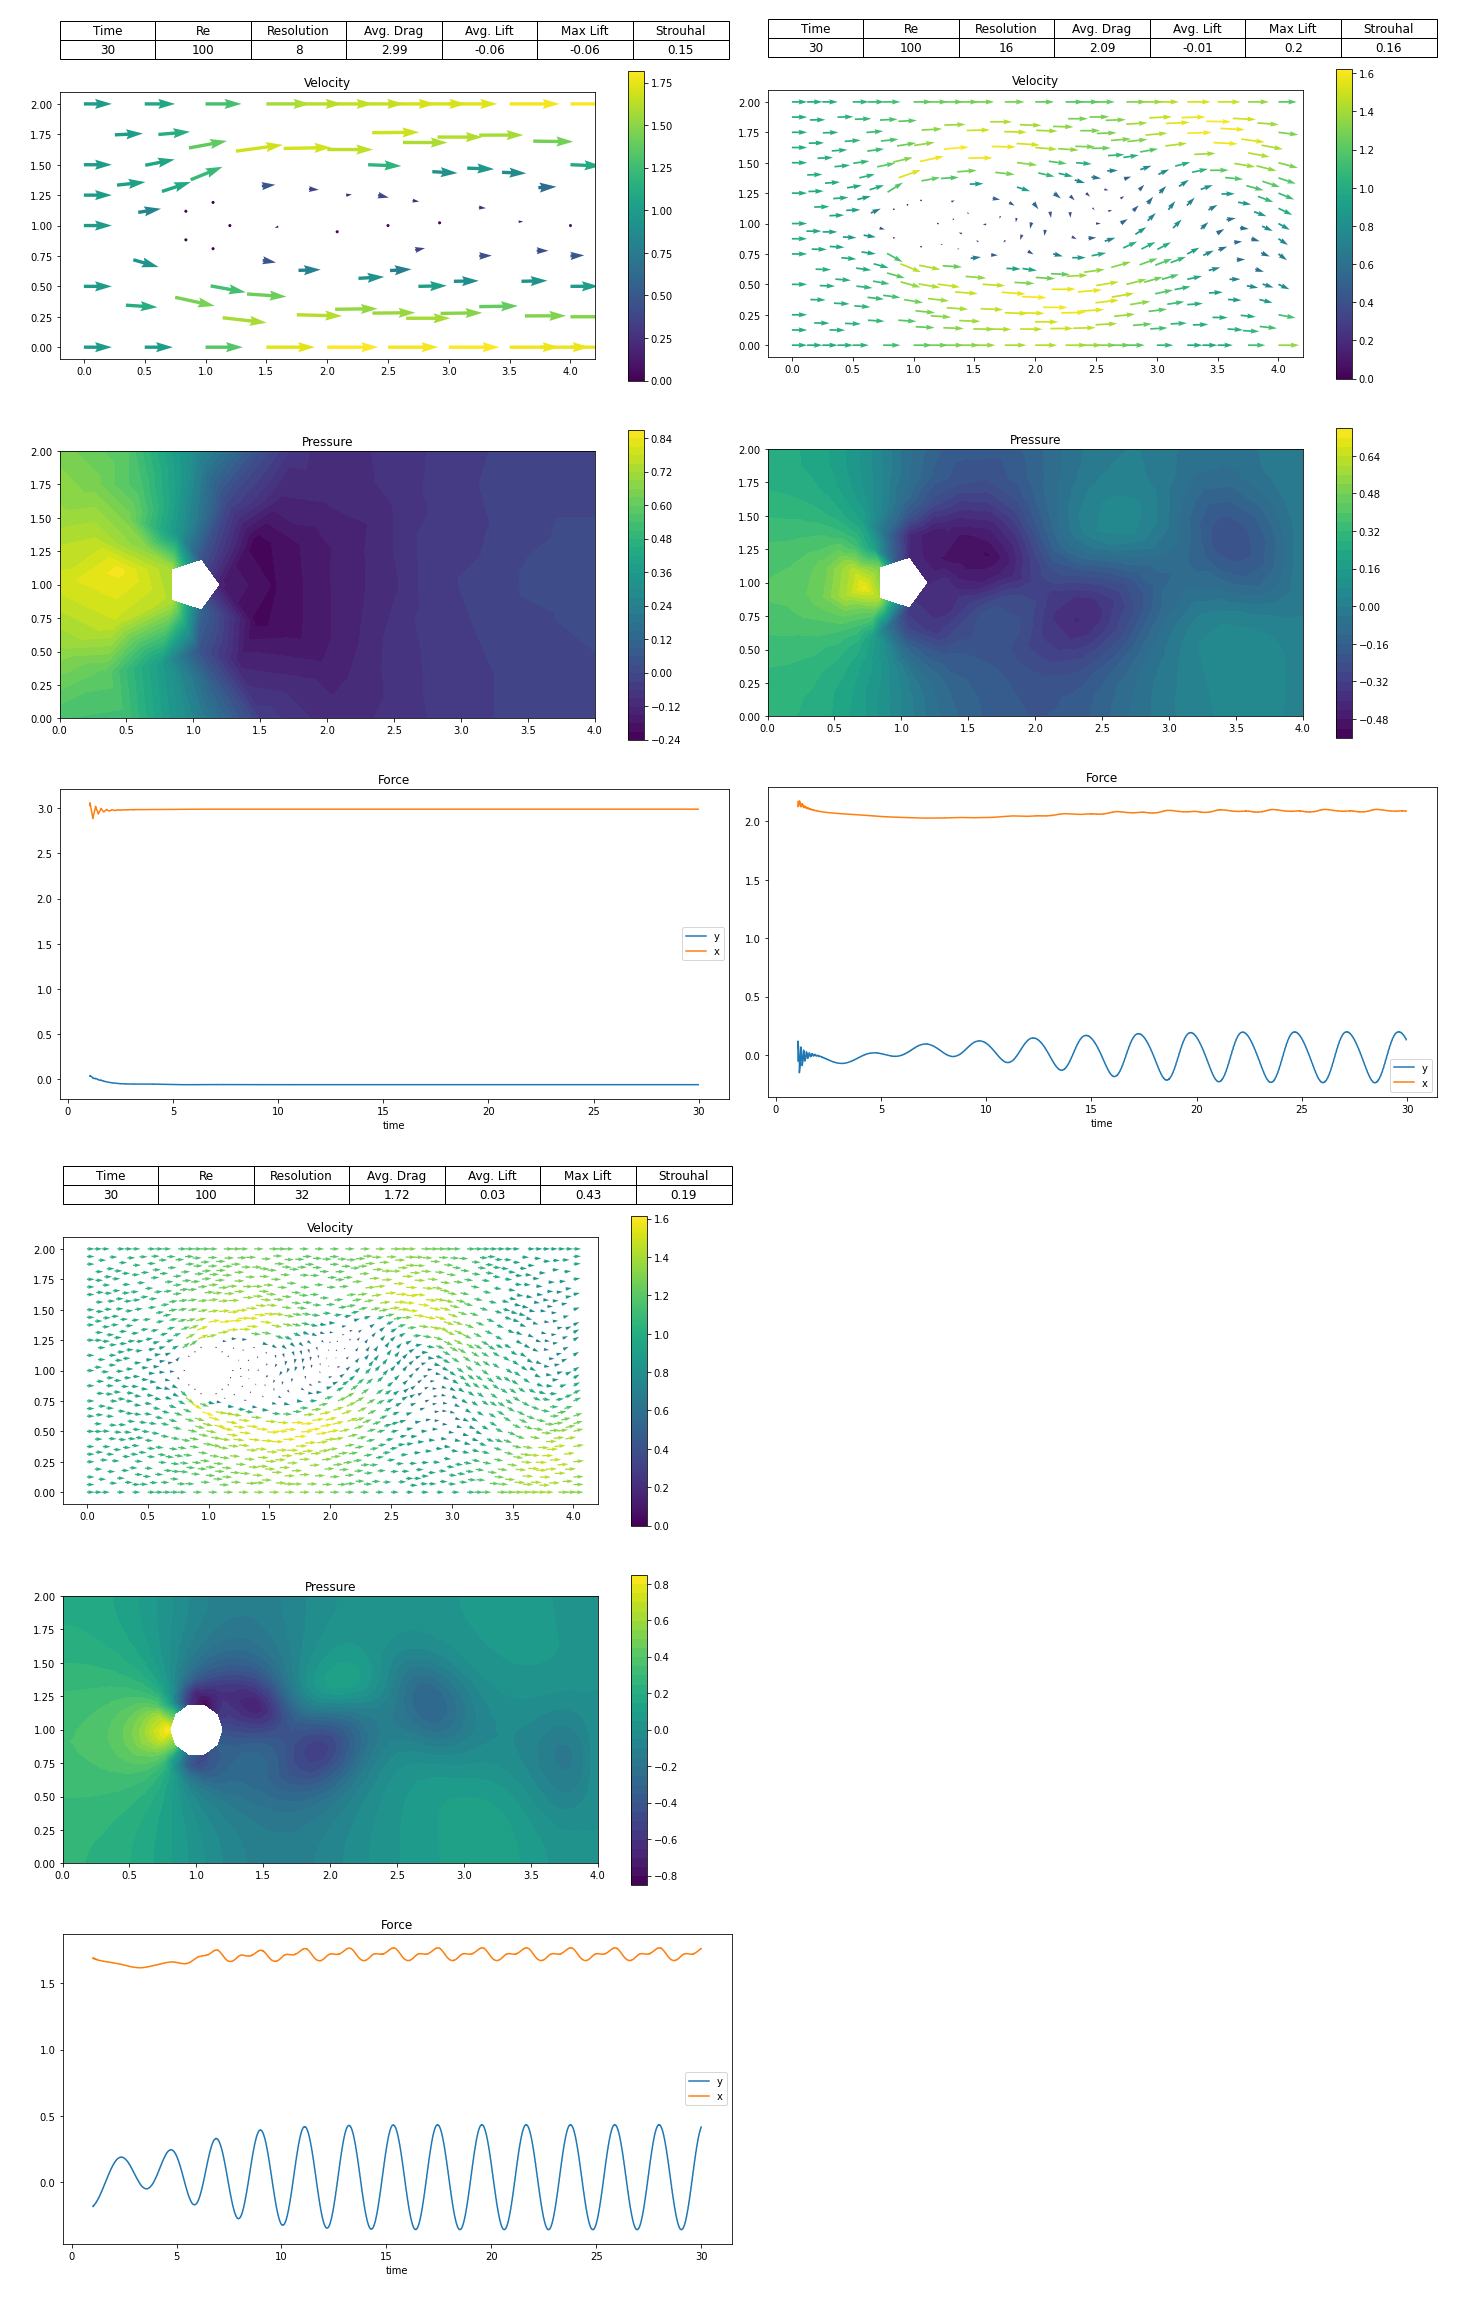

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street).

In Figure 1, we can see the result of the simulation for different Reynold's Numbers. For the low Reynold's numbers 1 and 10 we get a very viscous and stable flow (no oscillations in time). For the higher Reynolds numbers 100 and 1000, we get unsteady flow that oscillates in time, with a Karman vortex street behind the cylinder.

The drag coefficient is higher for the viscous flows, and gradually decreases as the Reynolds number increases. With Re = 1000, the average drag coefficient is 1.57. [Wikipedia](https://en.wikipedia.org/wiki/Drag_coefficient) lists a drag coefficent of 1.17 for a cylinder at a Reynolds number above 10000, so we would expect it to decrease to around 1.17 if we were to increase Re even further.

The average lift is close to 0 in all cases, which we could expect due to symmetry. However, for the oscillating cases, we get an increasing maximum lift coefficient with increasing Reynolds number (0.43 and 0.69).

The Karman vortex street has a Strouhal number close to 0.2 for both Re = 100 and Re = 1000.

In Figure 2, we can see the effects of changing the resolution of the mesh at Re = 100. For a more coarse mesh, the flow becomes more similar to a viscous flow and the vortex street disappears. The drag and lift also behaves similar to the viscous flow, with drag increasing and lift decreasing as the resolution become coarser. The Strouhal number also decreases slightly.

## Paraview videos

Paraview video files of the flow at Re = 100 has been submitted together with this notebook.